In [1]:
# basic import
import numpy as np
import pandas as pd

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn import set_config

# split data into training and testing sets
from sklearn.model_selection import train_test_split

# modeling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# type of training
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold

# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, make_scorer
from sklearn.metrics import confusion_matrix, auc,roc_curve, RocCurveDisplay

# tuning parameters
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# save model
import joblib

# others
import warnings
warnings.filterwarnings('ignore')


### <h2 style="font-family: fantasy; color='green';opacity: 0.95;">Preprocesamiento de datos</h2>

In [2]:
df = pd.read_csv("../data/Human_Resources.csv")
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [3]:
# Eliminar campos que no aportaran informacion al modelo
df.drop(["EmployeeCount","StandardHours","Over18","EmployeeNumber"], axis=1, inplace=True)

In [4]:
# Reemplazar las columnas "Attrition" y "Overtime"  por valores enteros
# 0:No 1: Yes
df["Attrition"] = df["Attrition"].apply(lambda x: 1 if x == "Yes" else 0)
#df["OverTime"] = df["OverTime"].apply(lambda x: 1 if x == "Yes" else 0)


#### Tratamiento de outliers

In [5]:
df_copy = df.copy()
df_copy = df_copy.drop(["PerformanceRating","Attrition"],axis=1)
num_cols = list(df_copy.select_dtypes(exclude=[object]).columns)

In [6]:
from feature_engine.outliers import Winsorizer

# The values to cap variables are determined using: a Gaussian approximation. the inter-quantile range proximity rule (IQR)
windsoriser = Winsorizer(capping_method='iqr', 
                          tail='both', # aplicar para ambos lados de la caja y bigotes
                          fold=1.5,
                          variables=num_cols) # variables sobre las cuales realizar el tratamiento de outliers
# entrenar modelo 
windsoriser.fit(df)
# transformar en base a los datos entrenados
df = windsoriser.transform(df)

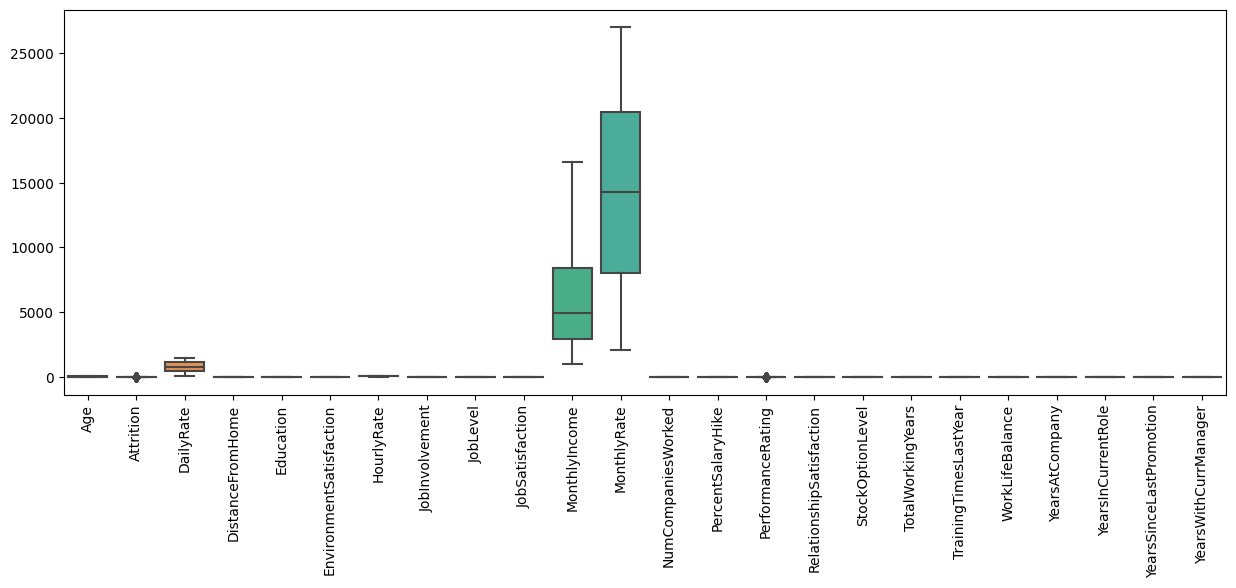

In [7]:
#boxplot general
plt.figure(figsize = [15, 5]) 
sns.boxplot(data = df)
#rotar las etiquetas del eje x 90 grados
plt.tick_params(axis='x', rotation=90)

#### Split X and Y variables (Variables independientes y dependiente)

In [8]:
X = df.drop(columns=["Attrition"], axis=1)
y = df["Attrition"]

#### Pipelines

In [9]:
# Retrieve categorical and numerical columns names
numerical_columns = list(X.select_dtypes(exclude=[object]).columns)
categorical_columns = list(X.select_dtypes(include=[object]).columns)

print(f"There are {len(numerical_columns)} numerical features: {numerical_columns}")
print(f"There are {len(categorical_columns)} categorical features: {categorical_columns}")

There are 23 numerical features: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
There are 7 categorical features: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']


Creando los pipelines de preprocesamiento y estandarizacion de los datos

In [10]:
# Define Pipeline

# for numerical columns
num_pipeline = Pipeline(
    steps = [
        #("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=False))
    ]
)

# for categorical columns
cat_pipeline = Pipeline(
    steps = [
        #("imputer", SimpleImputer(strategy="most_frequent")),
        ("one_hot_encoder", OneHotEncoder()), 
        ("scaler", StandardScaler(with_mean=False)) # (with_mean=False)
    ]
)

# Combination of pipelines
preprocessor = ColumnTransformer(
    [
        ("num_pipeline", num_pipeline, numerical_columns),
        ("cat_pipelines", cat_pipeline, categorical_columns)
    ]
)


In [11]:
# show structure of pipelines
set_config(display="diagram")
preprocessor

ColumnTransformer(transformers=[('num_pipeline',
                                 Pipeline(steps=[('scaler',
                                                  StandardScaler(with_mean=False))]),
                                 ['Age', 'DailyRate', 'DistanceFromHome',
                                  'Education', 'EnvironmentSatisfaction',
                                  'HourlyRate', 'JobInvolvement', 'JobLevel',
                                  'JobSatisfaction', 'MonthlyIncome',
                                  'MonthlyRate', 'NumCompaniesWorked',
                                  'PercentSalaryHike', 'PerformanceRating',
                                  'RelationshipSa...
                                  'StockOptionLevel', 'TotalWorkingYears',
                                  'TrainingTimesLastYear', 'WorkLifeBalance',
                                  'YearsAtCompany', 'YearsInCurrentRole',
                                  'YearsSinceLastPromotion',
                                  'YearsWithCurrManager']),
                                ('cat_pipelines',
                                 Pipeline(steps=[('one_hot_encoder',
                                                  OneHotEncoder()),
                                                 ('scaler',
                                                  StandardScaler(with_mean=False))]),
                                 ['BusinessTravel', 'Department',
                                  'EducationField', 'Gender', 'JobRole',
                                  'MaritalStatus', 'OverTime'])])

In [12]:
# Preprocess the data using the pipeline
preprocessed_data = preprocessor.fit_transform(X)
preprocessed_data

array([[4.4895759 , 2.73197066, 0.12339423, ..., 2.14421538, 0.        ,
        2.21998666],
       [5.36559072, 0.69166952, 0.98715385, ..., 0.        , 2.21998666,
        0.        ],
       [4.0515685 , 3.40380736, 0.24678846, ..., 2.14421538, 0.        ,
        2.21998666],
       ...,
       [2.95654999, 0.38426085, 0.49357693, ..., 0.        , 0.        ,
        2.21998666],
       [5.36559072, 2.53612158, 0.24678846, ..., 0.        , 2.21998666,
        0.        ],
       [3.72306295, 1.5568762 , 0.98715385, ..., 0.        , 2.21998666,
        0.        ]])

#### Guardar el objeto preprocesador

In [86]:
import joblib
# ----------------------------------------------------------------
# Save the preprocessor object
joblib.dump(preprocessor, './preprocessor.joblib') # preprocessor.pkl

# Load the preprocessor object
preprocessor = joblib.load('./preprocessor.joblib') # preprocessor.pkl

#### Balancear datos

<Axes: >

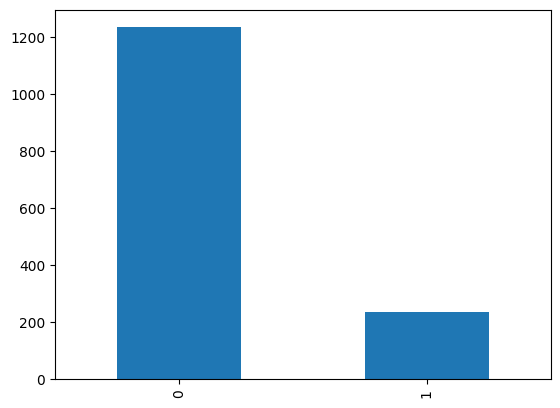

In [13]:
y.value_counts().plot(kind="bar") # antes de aplicar smote

In [14]:
#importar la librería
from imblearn.over_sampling import SMOTE

#crear un objeto SMOTE con la proporción deseada
sm = SMOTE(sampling_strategy=0.7)

#aplicar SMOTE a los datos X e y
X, y = sm.fit_resample(preprocessed_data, y)

<Axes: >

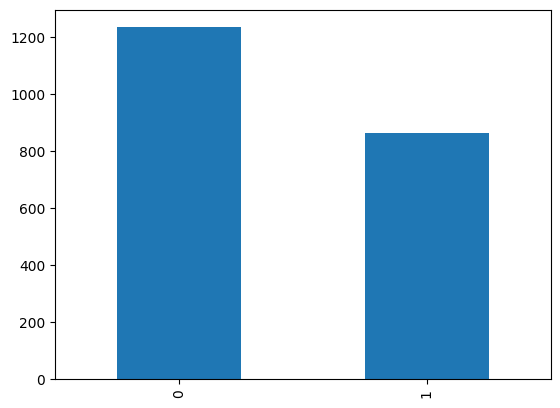

In [15]:
y.value_counts().plot(kind="bar") # antes de aplicar smote

#### Dividir los datos en entrenamiento y prueba

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### <h2 style="font-family: fantasy; opacity: 0.95;">Modelado</h2>

In [17]:
np.random.seed(123456)

In [18]:
# Initialize the models
models = {
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "AdaBoostClassifier": AdaBoostClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "SVC": SVC(),
    "CatBoostClassifierr": CatBoostClassifier(),
    "XGBClassifier":XGBClassifier()
}

#### FIT without tuning

In [19]:
def fit_models(X_train, y_train, X_test, y_test, models):
    trained_models = {}
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        trained_models[name] = model
        print(f"\n>>> {name} model done <<<\n")
    return trained_models

In [20]:
trained_models=fit_models(X_train, y_train, X_test, y_test, models)


>>> KNN model done <<<


>>> Decision Tree model done <<<




>>> RandomForestClassifier model done <<<


>>> AdaBoostClassifier model done <<<


>>> GradientBoostingClassifier model done <<<


>>> SVC model done <<<

Learning rate set to 0.012844
0:	learn: 0.6871452	total: 155ms	remaining: 2m 34s
1:	learn: 0.6790718	total: 168ms	remaining: 1m 23s
2:	learn: 0.6712691	total: 181ms	remaining: 1m
3:	learn: 0.6645689	total: 203ms	remaining: 50.7s
4:	learn: 0.6576978	total: 217ms	remaining: 43.1s
5:	learn: 0.6496161	total: 231ms	remaining: 38.2s
6:	learn: 0.6432565	total: 244ms	remaining: 34.6s
7:	learn: 0.6365421	total: 256ms	remaining: 31.8s
8:	learn: 0.6292274	total: 271ms	remaining: 29.8s
9:	learn: 0.6219976	total: 283ms	remaining: 28s
10:	learn: 0.6151462	total: 296ms	remaining: 26.7s
11:	learn: 0.6096688	total: 309ms	remaining: 25.4s
12:	learn: 0.6040710	total: 321ms	remaining: 24.4s
13:	learn: 0.5984292	total: 333ms	remaining: 23.4s
14:	learn: 0.5939708	total: 346ms	remaining: 22.7s
15:	learn: 0.5880988	total: 360ms	remaining: 22.1s
16:	learn:

#### Mostrar la matriz de confusion

In [21]:
def plot_confusion_matrix(trained_models, X_test, y_test):
    #crear una figura con varias subfiguras
    fig, axes = plt.subplots(2, 4, figsize=(15, 10))

    #iterar sobre los modelos y los ejes
    for (name, model), ax in zip(trained_models.items(), axes.flatten()):
        #predecir las etiquetas de los datos de prueba
        y_pred = model.predict(X_test)
        #obtener la matriz de confusión
        cm = confusion_matrix(y_test, y_pred)
        #graficar la matriz de confusión usando seaborn
        sns.heatmap(cm, annot=True, fmt='d', ax=ax)
        #poner el título del modelo
        ax.set_title(name)

    #ajustar el espacio entre las subfiguras
    plt.tight_layout()
    #mostrar la figura
    plt.show()

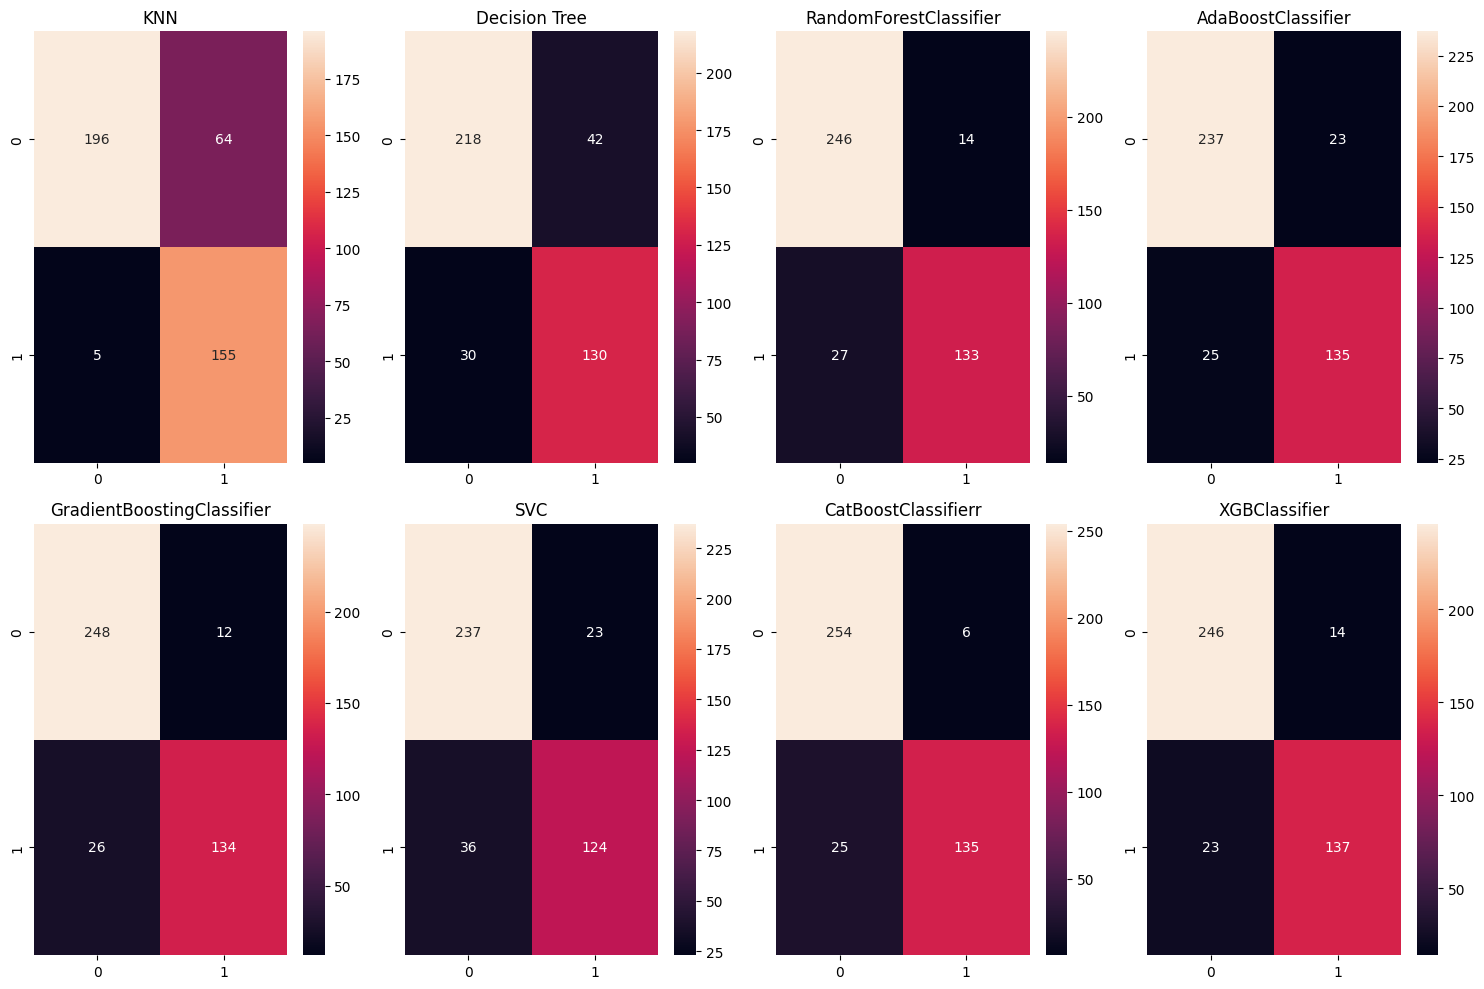

In [22]:
plot_confusion_matrix(trained_models, X_test, y_test)

#### Evaluacion del rendimiento de los modelos

In [23]:
def evaluate_models(X_train, y_train, X_test, y_test, models, re_train = False):
    report = {}

    for i in range(len(list(models))):
        model = list(models.values())[i] # Retrieve the model

        # -------------------------------------------------------
        if re_train:                
            # fit the model
            model.fit(X_train,y_train) 
        # -------------------------------------------------------
        # Get the predictions
        y_train_pred = model.predict(X_train) # train
        y_test_pred = model.predict(X_test) # test
        # -------------------------------------------------------
        # Get the scores
        # Train
        accuracy_train_model = accuracy_score(y_train, y_train_pred).round(3)
        f1_train_model = f1_score(y_train, y_train_pred).round(3)
        report_train = classification_report(y_train, y_train_pred)
        # Test
        accuracy_test_model = accuracy_score(y_test, y_test_pred).round(3)
        f1_test_model = f1_score(y_test, y_test_pred).round(3)
        report_test = classification_report(y_test, y_test_pred)
        # -------------------------------------------------------

        # Make the report
        report[list(models.keys())[i]] = (f1_train_model,f1_test_model,accuracy_train_model,accuracy_test_model)

        # -------------------------------------------------------
        
        print(f'Model {list(models.keys())[i]}')
        
        #print(f"Acuracy Train: {accuracy_train_model}\n")
        print(report_train,"\n")
        #print(f"Acuracy Test: {accuracy_test_model}\n")
        print(report_test,"\n")
        
        
    return report

In [24]:
# Evaluate the models
model_report:dict=evaluate_models(X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test,
                                    models=models)

Model KNN
              precision    recall  f1-score   support

           0       0.98      0.81      0.89       973
           1       0.79      0.98      0.87       703

    accuracy                           0.88      1676
   macro avg       0.88      0.89      0.88      1676
weighted avg       0.90      0.88      0.88      1676
 

              precision    recall  f1-score   support

           0       0.98      0.75      0.85       260
           1       0.71      0.97      0.82       160

    accuracy                           0.84       420
   macro avg       0.84      0.86      0.83       420
weighted avg       0.87      0.84      0.84       420
 

Model Decision Tree
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       973
           1       1.00      1.00      1.00       703

    accuracy                           1.00      1676
   macro avg       1.00      1.00      1.00      1676
weighted avg       1.00      1.00      1

In [25]:
#convertirlo a un dataframe de pandas
df_scores = pd.DataFrame.from_dict(model_report, orient='index', columns=['f1_score_train', 'f1_score_test', 'Accuracy_train', 'Accuracy_test']).sort_values(by=["Accuracy_test"],ascending=False)
#mostrar el dataframe
df_scores


,f1_score_train,f1_score_test,Accuracy_train,Accuracy_test
CatBoostClassifierr,0.997,0.897,0.998,0.926
XGBClassifier,1.000,0.881,1.000,0.912
GradientBoostingClassifier,0.957,0.876,0.965,0.910
RandomForestClassifier,1.000,0.866,1.000,0.902
AdaBoostClassifier,0.890,0.849,0.909,0.886
SVC,0.850,0.808,0.875,0.860
KNN,0.872,0.818,0.879,0.836
Decision Tree,1.000,0.783,1.000,0.829


#### Graficar la curva ROC

In [26]:
def plot_RocCurve(trained_models, X_test, y_test):
    fig, axes = plt.subplots(2, 4, figsize=(15, 10))

    for (name, model), ax in zip(trained_models.items(), axes.flatten()):
        #model.fit(X_train, y_train)
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_pred_proba = model.decision_function(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr), estimator_name=name)
        roc_display.plot(ax=ax)
        ax.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guess')
        ax.legend()

    plt.tight_layout()
    plt.show()

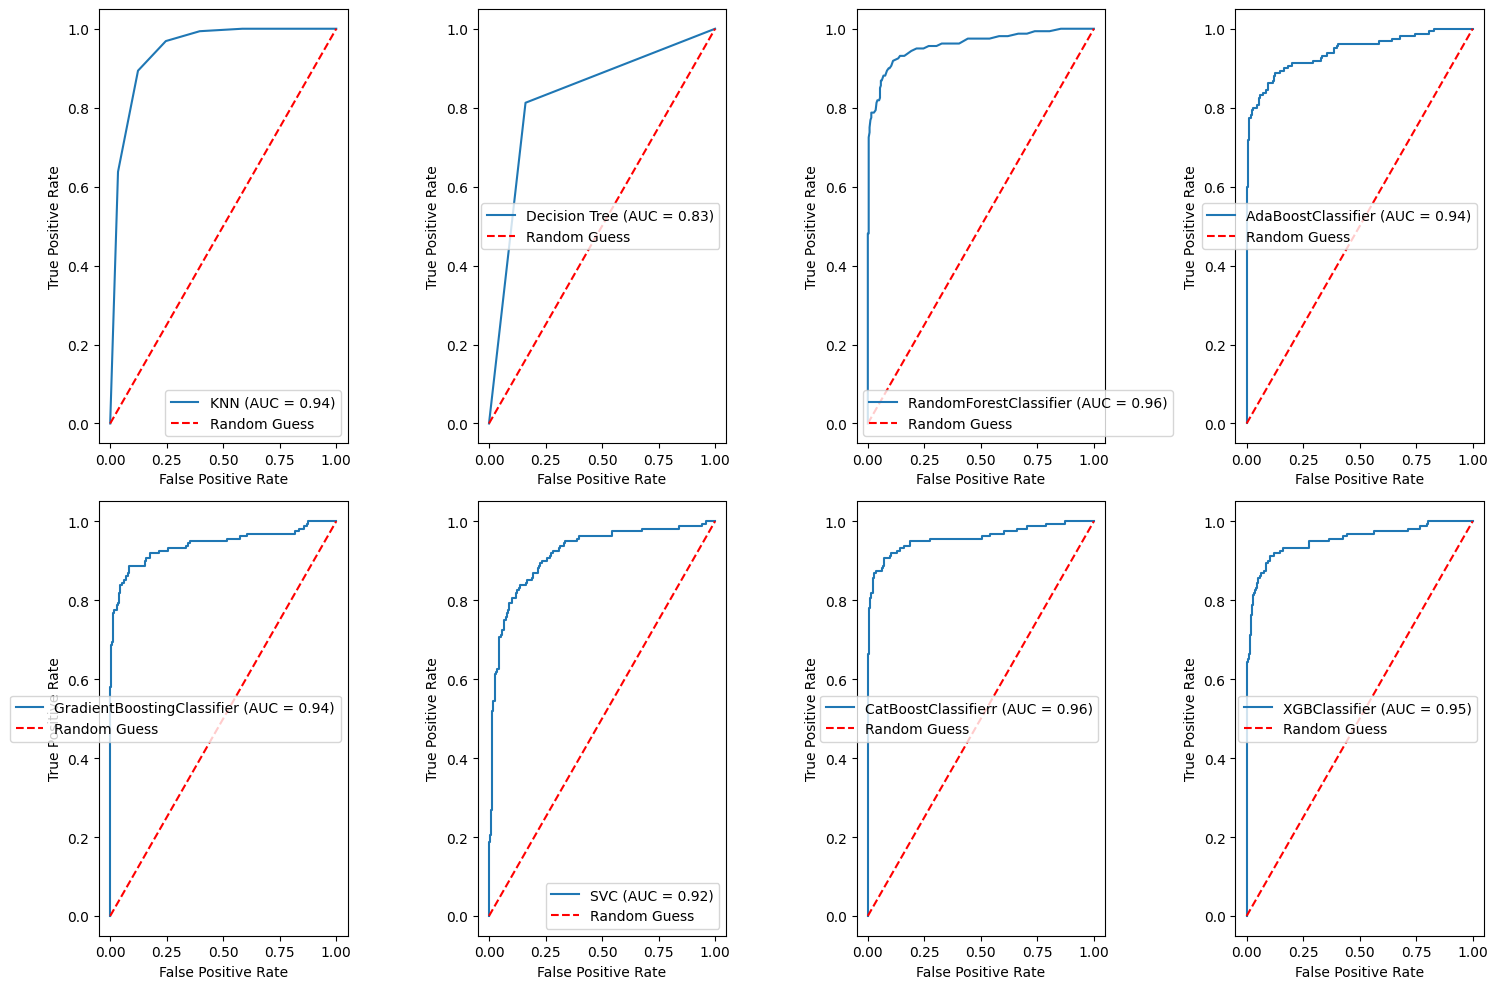

In [27]:
plot_RocCurve(trained_models, X_test, y_test)

#### Fit usando tuneo de hiperparametros

In [33]:
params = {
    "KNN": {
        "n_neighbors": [3, 5, 7],
        "weights": ["uniform", "distance"]
    },
    "Decision Tree": {
        "criterion": ["gini", "entropy"],
        "max_depth": [None, 5, 10, 20],
        "min_samples_split": [2, 5, 10]
    },
    "Random Forest": {
        "n_estimators": [100, 200, 500],
        "max_depth": [None, 5, 10, 20],
        "min_samples_split": [2, 5, 10],
        "max_features": ["sqrt", "log2"]
    },
    "AdaBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 1.0]
    },
    "Gradient Boosting": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 1.0],
        "max_depth": [None, 5, 10, 20],
        "min_samples_split": [2, 5, 10],
        "max_features": ["sqrt", "log2"]
    },
    "SVM": {
        "C": [0.1, 1, 10],
        "kernel": ["linear", "rbf", "poly"],
        "gamma": ["scale", "auto"]
    },
    "CatBoost": {
        "iterations": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 1.0],
        "depth": [3, 5, 7]
    },
    "XGBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 1.0],
        "max_depth": [None, 5, 10, 20],
        "min_child_weight": [1, 5, 10],
        "gamma": [0, 0.1, 0.5]
    }
}

In [48]:
def evaluate_models_tuning(X_train, y_train, X_test, y_test, models, param,cv):
    report_full = {}
    report = {}

    for name, model in models.items():
        if name in param:
            gs = GridSearchCV(model, param[name], cv=cv) # cross validation
            gs.fit(X_train, y_train)
            best_model = gs.best_estimator_

        best_model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # -------------------------------------------------------
        # Get the scores of the best model
        # Train
        accuracy_train_model = accuracy_score(y_train, y_train_pred).round(3)
        f1_train_model = f1_score(y_train, y_train_pred).round(3)
        report_train = classification_report(y_train, y_train_pred)
        # Test
        accuracy_test_model = accuracy_score(y_test, y_test_pred).round(3)
        f1_test_model = f1_score(y_test, y_test_pred).round(3)
        report_test = classification_report(y_test, y_test_pred)

        # -------------------------------------------------------
        # Make the report
        report_full[name] = (f1_train_model,f1_test_model,accuracy_train_model,accuracy_test_model)
        report[name] = accuracy_test_model
        print(f'\nModel {name}')
        
        # -------------------------------------------------------
        #scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1_macro")
        #print("- Train f1_macro: {:.3f}".format(scores.mean()))
        #print("- Train score: {:.3f}".format(best_model.score(X_test, y_test)))
        print("- Train Accuracy: {:.3f}".format(accuracy_train_model))
        print("- Test Accuracy: {:.3f}".format(accuracy_test_model))
       

    return report_full,report

In [55]:
model_report_full,model_report=evaluate_models_tuning(X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test,
                                    models=models, param=params,cv=5)


Model KNN
- Train Accuracy: 0.879
- Test Accuracy: 0.836

Model Decision Tree
- Train Accuracy: 1.000
- Test Accuracy: 0.829

Model RandomForestClassifier
- Train Accuracy: 1.000
- Test Accuracy: 0.912

Model AdaBoostClassifier
- Train Accuracy: 0.909
- Test Accuracy: 0.886

Model GradientBoostingClassifier
- Train Accuracy: 0.965
- Test Accuracy: 0.910

Model SVC
- Train Accuracy: 0.875
- Test Accuracy: 0.860

Model CatBoostClassifierr
- Train Accuracy: 0.998
- Test Accuracy: 0.926

Model XGBClassifier
- Train Accuracy: 1.000
- Test Accuracy: 0.912


In [56]:
df_scores2 = pd.DataFrame.from_dict(model_report_full, orient='index', columns=['f1_score_train', 'f1_score_test', 'Accuracy_train', 'Accuracy_test']).sort_values(by=["Accuracy_test"],ascending=False)
#mostrar el dataframe
df_scores2

,f1_score_train,f1_score_test,Accuracy_train,Accuracy_test
CatBoostClassifierr,0.997,0.897,0.998,0.926
RandomForestClassifier,1.000,0.878,1.000,0.912
XGBClassifier,1.000,0.881,1.000,0.912
GradientBoostingClassifier,0.957,0.876,0.965,0.910
AdaBoostClassifier,0.890,0.849,0.909,0.886
SVC,0.850,0.808,0.875,0.860
KNN,0.872,0.818,0.879,0.836
Decision Tree,1.000,0.783,1.000,0.829


In [57]:
model_report

{'KNN': 0.836,
 'Decision Tree': 0.829,
 'RandomForestClassifier': 0.912,
 'AdaBoostClassifier': 0.886,
 'GradientBoostingClassifier': 0.91,
 'SVC': 0.86,
 'CatBoostClassifierr': 0.926,
 'XGBClassifier': 0.912}

#### Obtain the best model

In [81]:
# Get the best model score from dictionary
best_model_score = max(sorted(model_report.values()))
# Get best model name from dictionary
index_best_model = list(model_report.values()).index(best_model_score)
best_model_name = list(model_report.keys())[index_best_model]
# Get the best model
best_model = models[best_model_name]

# limit the model score
threshold = 0.9 # limit
if best_model_score < threshold:
    print("No best model found!")
else:
    print(f"Best found model on both training and testing dataset >>> {best_model_name} <<<")

Best found model on both training and testing dataset >>> CatBoostClassifierr <<<


In [60]:
X[123]

array([4.0515685 , 3.40380736, 0.24678846, 1.953475  , 3.6606224 ,
       4.5269995 , 2.81167773, 0.90369885, 2.72116016, 0.48025392,
       0.33673608, 2.44516624, 4.09982514, 8.31714321, 1.85041082,
       0.        , 0.95872767, 2.89128428, 4.24787488, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       2.20272988, 0.        , 2.10182595, 0.        , 0.        ,
       0.        , 0.        , 0.        , 4.35728207, 0.        ,
       0.        , 2.04124145, 0.        , 0.        , 2.62479495,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 2.14421538, 0.        ,
       2.21998666])

#### Save the model

In [82]:
file_path = "../Recursos Humanos/"
file_name = "model.pkl"

with open(file_path + file_name, "wb") as file_obj_out:
    pickle.dump(best_model, file_obj_out)